In [2170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline




In [2171]:
df = pd.read_csv('/Users/mikeredshaw/Downloads/data_set_hackathon.csv')

In [2172]:
df.head()

,order_date,requested_delivery_date,Customer Country Code,Product Code,Description,order_type,Customer Order Code,value,Curr,items,Route
0,13.07.2009,28.01.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435553,2337.00,RUB,6,RU0001
1,15.07.2009,24.03.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435694,10160.25,RUB,23,RU0001
2,16.07.2009,04.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435741,2992.50,RUB,7,RU0001
3,17.07.2009,04.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435907,4061.25,RUB,9,RU0001
4,21.07.2009,01.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435963,2208.75,RUB,5,RU0001


Convert dates to datetime

In [2173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_date               2420 non-null   object 
 1   requested_delivery_date  2420 non-null   object 
 2   Customer Country Code    2420 non-null   object 
 3   Product Code             2420 non-null   object 
 4   Description              2420 non-null   object 
 5   order_type               2420 non-null   object 
 6   Customer Order Code      2420 non-null   int64  
 7   value                    2420 non-null   float64
 8   Curr                     2420 non-null   object 
 9   items                    2420 non-null   object 
 10  Route                    2420 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 208.1+ KB


Removing nulls and \N from Data

In [2174]:
df.fillna(0, inplace=True)
df.replace(r'\N', 0, inplace=True)

Renaming columns

In [2175]:
df.rename(columns={'order_date': 'Order Date', 'requested_delivery_date': 'Requested Delivery Date', 'order_type': 'Order Type', 'value': 'Value', 'Curr': 'Currency', 'items': 'Items'}, inplace=True)

Removing negative Lead Day values

In [2176]:
negative_rows = df[df['Value'] < 0]
print(negative_rows)

     Order Date Requested Delivery Date Customer Country Code Product Code  \
929  28.02.2011              15.09.2011                    CH    L12136100   

                     Description Order Type  Customer Order Code  Value  \
929  Parka Outdoor Lifestyle STD         VO           3200633089  -0.03   

    Currency Items   Route  
929      CHF     0  CH0001  


In [2177]:
df = df[df['Value'] >= 0]

In [2178]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d.%m.%Y')
df['Requested Delivery Date'] = pd.to_datetime(df['Requested Delivery Date'], format='%d.%m.%Y')

df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month

df['Delivery Year'] = df['Requested Delivery Date'].dt.year
df['Delivery Month'] = df['Requested Delivery Date'].dt.month

In [2179]:
df.dtypes

Order Date                 datetime64[ns]
Requested Delivery Date    datetime64[ns]
Customer Country Code              object
Product Code                       object
Description                        object
Order Type                         object
Customer Order Code                 int64
Value                             float64
Currency                           object
Items                              object
Route                              object
Order Year                          int64
Order Month                         int64
Delivery Year                       int64
Delivery Month                      int64
dtype: object

In [2180]:
df['Order Year'].unique()

array([2009, 2010, 2011, 2012])

In [2181]:
df['Delivery Year'].unique()

array([2010, 2011, 2012, 2013])

In [2182]:
df['Items'] = df['Items'].astype(int)

Review orders on a monthly level.

In [2183]:
monthly_orders = df.groupby(['Order Year', 'Order Month']).agg({'Value': 'sum', 'Items': 'sum'}).reset_index()
monthly_orders = monthly_orders.sort_values(by=['Order Year', 'Order Month'])

In [2184]:
monthly_orders = monthly_orders.sort_values(by=['Order Year', 'Order Month']).reset_index(drop=True)
monthly_orders.head(30)


,Order Year,Order Month,Value,Items
0,2009,7,462065.60,1067
1,2009,8,45673.86,137
2,2009,9,1692.29,70
3,2009,10,97.42,10
4,2009,11,12492.89,630
5,2009,12,159934.26,361
6,2010,1,20266.37,187
7,2010,2,74925.83,370
8,2010,3,14282.48,314
9,2010,4,804.00,81


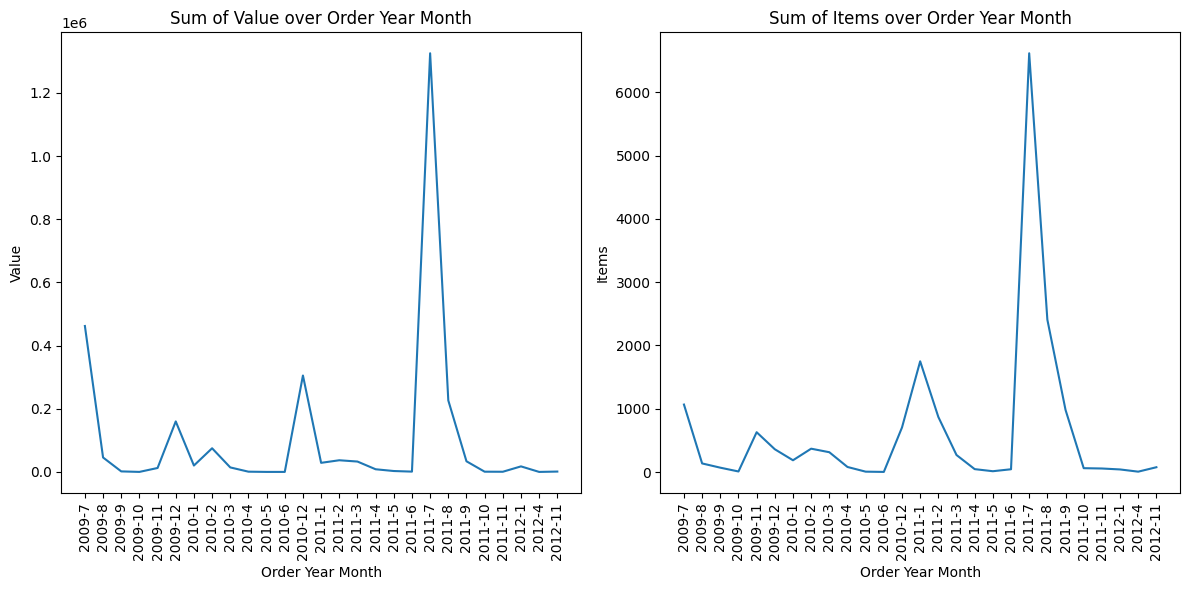

In [2185]:
monthly_orders['Order Year Month'] = monthly_orders['Order Year'].astype(str) +"-" + monthly_orders['Order Month'].astype(str)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data=monthly_orders, x='Order Year Month', y='Value')
plt.xlabel('Order Year Month')
plt.ylabel('Value')
plt.title('Sum of Value over Order Year Month')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.lineplot(data=monthly_orders, x='Order Year Month', y='Items')
plt.xlabel('Order Year Month')
plt.ylabel('Items')
plt.title('Sum of Items over Order Year Month')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


In [2186]:
monthly_orders['Order Year Month'].unique()

array(['2009-7', '2009-8', '2009-9', '2009-10', '2009-11', '2009-12',
       '2010-1', '2010-2', '2010-3', '2010-4', '2010-5', '2010-6',
       '2010-12', '2011-1', '2011-2', '2011-3', '2011-4', '2011-5',
       '2011-6', '2011-7', '2011-8', '2011-9', '2011-10', '2011-11',
       '2012-1', '2012-4', '2012-11'], dtype=object)

In [2187]:
monthly_orders.describe()

,Order Year,Order Month,Value,Items
count,27.000000,27.000000,2.700000e+01,27.000000
mean,2010.407407,6.370370,1.042372e+05,636.703704
std,0.971092,3.628394,2.675117e+05,1329.654808
min,2009.000000,1.000000,4.991000e+01,3.000000
25%,2010.000000,3.500000,8.926400e+02,46.000000
50%,2011.000000,6.000000,1.428248e+04,137.000000
75%,2011.000000,9.500000,4.131585e+04,667.500000
max,2012.000000,12.000000,1.325577e+06,6616.000000


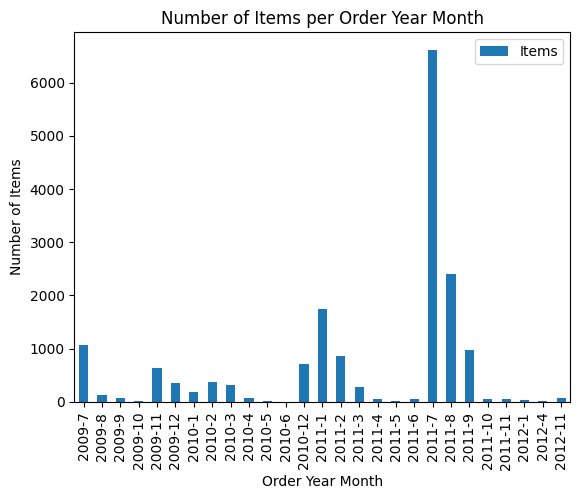

In [2188]:
monthly_orders.plot(x='Order Year Month', y='Items', kind='bar')
plt.xlabel('Order Year Month')
plt.ylabel('Number of Items')
plt.title('Number of Items per Order Year Month')
plt.show()


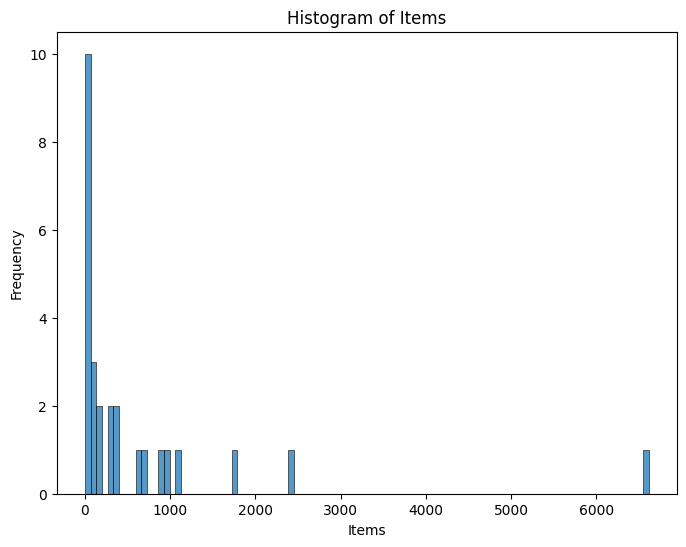

In [2189]:
plt.figure(figsize=(8, 6))
sns.histplot(data=monthly_orders, x='Items', bins=100)
plt.xlabel('Items')
plt.ylabel('Frequency')
plt.title('Histogram of Items')
plt.show()


Review orders on a seasonal basis.

In [2190]:
def month_to_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

df['O_Season'] = df['Order Month'].apply(month_to_season)
df['D_Season'] = df['Delivery Month'].apply(month_to_season)
df['O_Season_Num'] = df['O_Season'].map({'Winter': 1, 'Spring': 2, 'Summer': 3, 'Fall': 4})
df['D_Season_Num'] = df['D_Season'].map({'Winter': 1, 'Spring': 2, 'Summer': 3, 'Fall': 4})
df['Year-Season'] = df['Order Year'].astype(str) + '-' + df['O_Season_Num'].astype(str)

year_season_orders = df.groupby('Year-Season').agg({'Value': 'sum', 'Items': 'sum'}).reset_index()
year_season_orders['Year-Season'] = pd.Categorical(year_season_orders['Year-Season'], categories=sorted(df['Year-Season'].unique()), ordered=True)
year_season_orders = year_season_orders.sort_values('Year-Season')

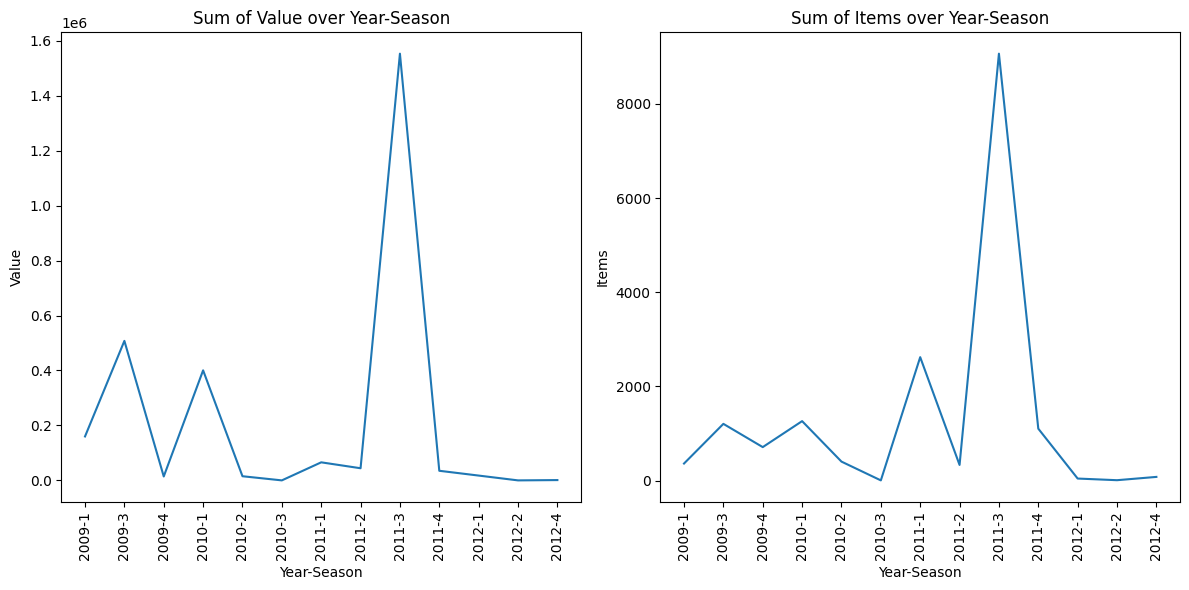

In [2191]:
import seaborn as sns
import matplotlib.pyplot as plt

year_season_orders = year_season_orders.sort_values('Year-Season')

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data=year_season_orders, x='Year-Season', y='Value')
plt.xlabel('Year-Season')
plt.ylabel('Value')
plt.title('Sum of Value over Year-Season')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.lineplot(data=year_season_orders, x='Year-Season', y='Items')
plt.xlabel('Year-Season')
plt.ylabel('Items')
plt.title('Sum of Items over Year-Season')
plt.xticks(rotation=90)

plt.tight_layout()


In [2192]:
Grouped_D_Season = df.groupby(['Delivery Year', 'D_Season_Num']).agg({'Value': 'sum', 'Items': 'sum'}).reset_index()
Grouped_D_Season['Delivery Year Season'] = Grouped_D_Season['Delivery Year'].astype(str) + '-' + Grouped_D_Season['D_Season_Num'].astype(str)


In [2193]:
Grouped_D_Season.head()

,Delivery Year,D_Season_Num,Value,Items,Delivery Year Season
0,2010,1,480163.07,1120,2010-1
1,2010,2,37124.60,164,2010-2
2,2010,3,67007.98,1059,2010-3
3,2010,4,208078.06,894,2010-4
4,2011,1,20612.00,65,2011-1


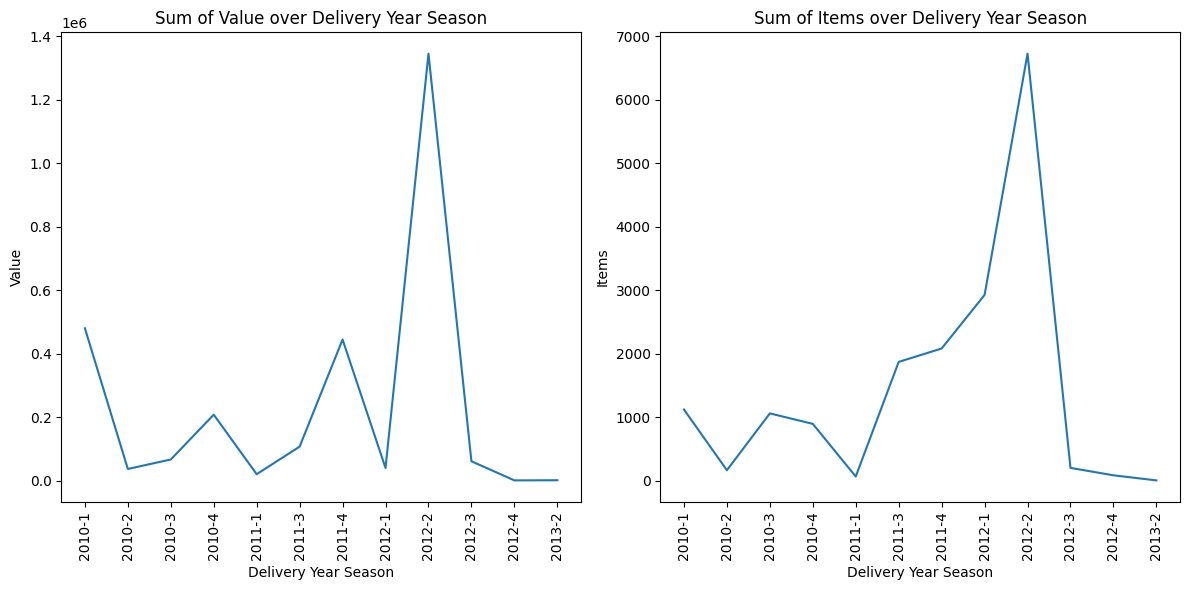

In [2194]:

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data=Grouped_D_Season, x='Delivery Year Season', y='Value')
plt.xlabel('Delivery Year Season')
plt.ylabel('Value')
plt.title('Sum of Value over Delivery Year Season')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.lineplot(data=Grouped_D_Season, x='Delivery Year Season', y='Items')
plt.xlabel('Delivery Year Season')
plt.ylabel('Items')
plt.title('Sum of Items over Delivery Year Season')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


Calculate Lead Time in days & months, value per item, Customer_ID, give season a numerical value.

In [2195]:
df['Lead_Time_Days'] = (df['Requested Delivery Date'] - df['Order Date']).dt.days
df['Lead_Time_Months'] = (df['Delivery Year'] - df['Order Year']) * 12 + (df['Delivery Month'] - df['Order Month'])

df['Value/Item'] = df['Value'] / df['Items']

df['Customer_ID'] = df['Customer Country Code'] + '-' + df['Route']

In [2196]:
negative_lead_time = df[df['Lead_Time_Days'] < 0]
print(negative_lead_time)
df = df[df['Lead_Time_Days'] >= 0]


    Order Date Requested Delivery Date Customer Country Code Product Code  \
477 2012-11-19              2012-11-16                    FR    L12134400   
523 2012-11-19              2012-11-16                    FR    L12134500   
583 2012-11-19              2012-11-16                    FR    L12134600   
742 2012-11-19              2012-11-16                    FR    L12135800   

                     Description Order Type  Customer Order Code  Value  \
477  Parka Outdoor Lifestyle STD         VO           3201061588  120.0   
523  Parka Outdoor Lifestyle STD         VO           3201061588  525.0   
583  Parka Outdoor Lifestyle STD         VO           3201061588   15.0   
742  Parka Outdoor Lifestyle STD         VO           3201061588  495.0   

    Currency  Items  ... Delivery Month  O_Season  D_Season  O_Season_Num  \
477      EUR      8  ...             11      Fall      Fall             4   
523      EUR     35  ...             11      Fall      Fall             4   
583    

In [2197]:
df['Lead_Time_Days'].describe(include='all')

count    2415.000000
mean      221.617391
std        52.510166
min        15.000000
25%       196.000000
50%       217.000000
75%       251.000000
max       459.000000
Name: Lead_Time_Days, dtype: float64

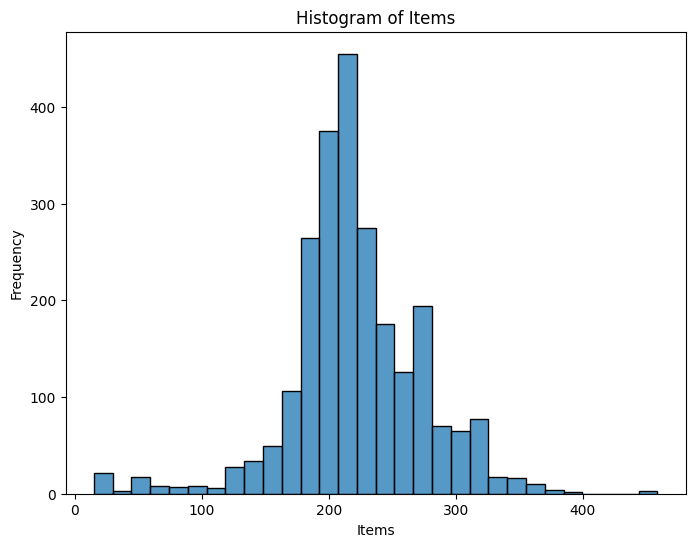

In [2198]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Lead_Time_Days', bins=30)
plt.xlabel('Items')
plt.ylabel('Frequency')
plt.title('Histogram of Items')
plt.show()

In [2199]:
product_dummies = pd.get_dummies(df['Product Code'])
df = pd.concat([df, product_dummies], axis=1)

df['advanced_order'] = (df['Lead_Time_Days'] >= 30).astype(int)
df['advanced_order_amount'] = df['Items'] * df['advanced_order']
df['urgent_order_amount'] = df['Items'] - df['advanced_order_amount']


Make Average Selection rate of product per season:

In [2200]:
total_items_per_season = df.groupby('O_Season_Num')['Items'].sum()
items_per_product_season = df.groupby(['O_Season_Num', 'Product Code'])['Items'].sum().reset_index()
merged_df = pd.merge(items_per_product_season, total_items_per_season, on='O_Season_Num', suffixes=('', '_Total'))

merged_df['Selection_Rate'] = merged_df['Items'] / merged_df['Items_Total']
selection_rate_dict = merged_df.set_index(['O_Season_Num', 'Product Code'])['Selection_Rate'].to_dict()

df['Avg_Season_Selection_Rate'] = df.apply(lambda row: selection_rate_dict.get((row['O_Season_Num'], row['Product Code'])), axis=1)

Let's see how many variations in lead time months there are to determine how to categorize if an order is urgent, Advanced & Urgent, or Simply Advanced.

In [2201]:
df['Lead_Time_Months'].unique()


array([ 6,  8,  7, 10,  9,  5,  4,  3, 12, 11,  2,  0,  1, 15])

Set "Order Urgency" labels

Urgent is due to be delivered within 30 days. Advanced Urgent is within 30 and 60 days. Advanced is 60+ days lead time.

In [2202]:
df['Urgent'] = (df['Lead_Time_Days'] < 30).astype(int)
df['Advanced_Urgent'] = ((df['Lead_Time_Days'] >= 30) & (df['Lead_Time_Days'] <= 60)).astype(int)
df['Advanced'] = (df['Lead_Time_Days'] > 60).astype(int)



Now for each row, determine the number of items orders for each level of "order urgency"

In [2203]:
df['Urgent Items'] = df['Urgent'] * df['Items']
df['Advanced_Urgent_Items'] = df['Advanced_Urgent'] * df['Items']
df['Advanced_Items'] = df['Advanced'] * df['Items']


Lets save a copy of this DF, but clean the one we'll be using up a little bit.

In [2204]:
df2 = df.copy()

In [2205]:
df.columns

Index(['Order Date', 'Requested Delivery Date', 'Customer Country Code',
       'Product Code', 'Description', 'Order Type', 'Customer Order Code',
       'Value', 'Currency', 'Items', 'Route', 'Order Year', 'Order Month',
       'Delivery Year', 'Delivery Month', 'O_Season', 'D_Season',
       'O_Season_Num', 'D_Season_Num', 'Year-Season', 'Lead_Time_Days',
       'Lead_Time_Months', 'Value/Item', 'Customer_ID', 'L10705000',
       'L10705100', 'L10705200', 'L10705300', 'L10705400', 'L10705500',
       'L10705600', 'L10705700', 'L10850600', 'L10850700', 'L10850800',
       'L10850900', 'L10852800', 'L10852900', 'L10853100', 'L12134400',
       'L12134500', 'L12134600', 'L12134700', 'L12135800', 'L12135900',
       'L12136000', 'L12136100', 'L12916800', 'L12916900', 'L12917000',
       'L12917100', 'L12917700', 'L12917800', 'L12917900', 'L12918000',
       'L12918400', 'L12918500', 'L12918600', 'L12918700', 'L12918800',
       'L12918900', 'L12919000', 'L12919100', 'L12919200', 'advanc

In [2206]:
df.drop(['Description', 'Order Type', 'Currency'], axis=1, inplace=True)


Reordering columns in the DataFrame to make them make more sense

In [2207]:
df = df[[
    'Customer Order Code', 'Customer_ID', 'Order Date', 'Order Year', 'Order Month','O_Season', 'O_Season_Num',
    'Requested Delivery Date', 'Delivery Year', 'Delivery Month', 'D_Season', 'D_Season_Num', 'Year-Season',
    'Lead_Time_Days', 'Lead_Time_Months', 'Items', 'Value', 'Value/Item',
    'Route', 'Product Code', 'Customer Country Code', 'advanced_order',
    'advanced_order_amount', 'urgent_order_amount', 'Urgent', 'Advanced_Urgent', 'Advanced',
    'Urgent Items', 'Advanced_Urgent_Items', 'Advanced_Items', 'Avg_Season_Selection_Rate'
]]


In [2208]:
df.head()

,Customer Order Code,Customer_ID,Order Date,Order Year,Order Month,O_Season,O_Season_Num,Requested Delivery Date,Delivery Year,Delivery Month,...,advanced_order,advanced_order_amount,urgent_order_amount,Urgent,Advanced_Urgent,Advanced,Urgent Items,Advanced_Urgent_Items,Advanced_Items,Avg_Season_Selection_Rate
0,3200435553,RU-RU0001,2009-07-13,2009,7,Summer,3,2010-01-28,2010,1,...,1,6,0,0,0,1,0,0,6,0.017517
1,3200435694,RU-RU0001,2009-07-15,2009,7,Summer,3,2010-03-24,2010,3,...,1,23,0,0,0,1,0,0,23,0.017517
2,3200435741,RU-RU0001,2009-07-16,2009,7,Summer,3,2010-02-04,2010,2,...,1,7,0,0,0,1,0,0,7,0.017517
3,3200435907,RU-RU0001,2009-07-17,2009,7,Summer,3,2010-02-04,2010,2,...,1,9,0,0,0,1,0,0,9,0.017517
4,3200435963,RU-RU0001,2009-07-21,2009,7,Summer,3,2010-02-01,2010,2,...,1,5,0,0,0,1,0,0,5,0.017517


In [2209]:
df_month_lead = df.groupby(['Order Year', 'Order Month']).agg({'O_Season_Num':'max', 'Items': 'sum', 'Urgent Items': 'sum', 'Advanced_Urgent_Items': 'sum', 'Advanced_Items': 'sum'}).reset_index()


In [2210]:
df_month_lead.head()

,Order Year,Order Month,O_Season_Num,Items,Urgent Items,Advanced_Urgent_Items,Advanced_Items
0,2009,7,3,1067,0,0,1067
1,2009,8,3,137,0,0,137
2,2009,9,4,70,0,0,70
3,2009,10,4,10,0,0,10
4,2009,11,4,630,0,0,630


In [2211]:
df_demand_delivery = df.groupby([ 'Delivery Year', 'Delivery Month']).agg({'D_Season_Num':'max', 'Items': 'sum'}).reset_index()


In [2212]:
df_demand_delivery = df_demand_delivery.sort_values(by=['Delivery Year', 'Delivery Month'])


In [2213]:
df_demand_delivery

,Delivery Year,Delivery Month,D_Season_Num,Items
0,2010,1,1,338
1,2010,2,1,755
2,2010,3,2,134
3,2010,4,2,21
4,2010,5,2,9
5,2010,6,3,54
6,2010,7,3,750
7,2010,8,3,255
8,2010,9,4,663
9,2010,10,4,150


**I will now predict the choice probabilities of each product getting selected for an order**

Per row calculation (no aggregation)

In [2214]:
df.dropna(inplace=True)

In [2215]:
features = ['O_Season_Num', 'D_Season_Num','Order Year', 'Customer Country Code', 'Route', 'Order Month', 'Delivery Month', 'Delivery Year', 'Lead_Time_Days', 'Avg_Season_Selection_Rate', 'Items', 'Value', 'Value/Item','Lead_Time_Months', 'Urgent',
       'Advanced_Urgent', 'Advanced', 'Urgent Items', 'Advanced_Urgent_Items', 'Advanced_Items']

X = df[features]
y = df['Product Code']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

categorical_features = ['O_Season_Num', 'D_Season_Num', 'Customer Country Code', 'Route', 'Order Year', 'Delivery Year', 'Lead_Time_Months']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numerical_features = ['Lead_Time_Days', 'Avg_Season_Selection_Rate', 'Items', 'Value/Item', 'Urgent Items', 'Advanced_Urgent_Items',
       'Advanced_Items']
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

In [2216]:
df.columns

Index(['Customer Order Code', 'Customer_ID', 'Order Date', 'Order Year',
       'Order Month', 'O_Season', 'O_Season_Num', 'Requested Delivery Date',
       'Delivery Year', 'Delivery Month', 'D_Season', 'D_Season_Num',
       'Year-Season', 'Lead_Time_Days', 'Lead_Time_Months', 'Items', 'Value',
       'Value/Item', 'Route', 'Product Code', 'Customer Country Code',
       'advanced_order', 'advanced_order_amount', 'urgent_order_amount',
       'Urgent', 'Advanced_Urgent', 'Advanced', 'Urgent Items',
       'Advanced_Urgent_Items', 'Advanced_Items', 'Avg_Season_Selection_Rate'],
      dtype='object')

In [2217]:
features = ['O_Season_Num', 'D_Season_Num', 'Order Year', 'Delivery Year', 'Customer Country Code', 'Route', 'Items', 'Advanced_Items', 'Value/Item', 'Lead_Time_Days', 'Lead_Time_Months', 'Avg_Season_Selection_Rate']

X = df[features]
y = df['Product Code']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

categorical_features = ['O_Season_Num', 'D_Season_Num', 'Order Year', 'Delivery Year', 'Customer Country Code', 'Route']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numerical_features = ['Items', 'Advanced_Items', 'Value/Item', 'Lead_Time_Days', 'Lead_Time_Months', 'Avg_Season_Selection_Rate']
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

In [2218]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, multi_class='multinomial'))
])

In [2219]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded)
model.fit(X_train, y_train)

y_pred_probs = model.predict_proba(X_test)

logloss = log_loss(y_test, y_pred_probs)
print(f'Log Loss: {logloss:.4f}')

Log Loss: 1.6785


In [2220]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

probabilities = model.predict_proba(X)

prob_cols = [f'prob_{code}' for code in le.classes_]
df_probs = pd.DataFrame(probabilities, columns=prob_cols, index=X.index)

df_with_probs = df.join(df_probs)

seasonal_choice_probabilities = df_with_probs.groupby('O_Season_Num')[prob_cols].mean()

print(seasonal_choice_probabilities)






Accuracy: 0.4275
              prob_L10705000  prob_L10705100  prob_L10705200  prob_L10705300  \
O_Season_Num                                                                   
1                   0.001506        0.000912        0.001122        0.001520   
2                   0.000782        0.000444        0.000394        0.000369   
3                   0.015675        0.008147        0.010947        0.014206   
4                   0.017605        0.002329        0.004775        0.003472   

              prob_L10705400  prob_L10705500  prob_L10705600  prob_L10705700  \
O_Season_Num                                                                   
1                   0.001606        0.001462        0.001714        0.001054   
2                   0.001037        0.000325        0.001028        0.000408   
3                   0.017549        0.010780        0.015156        0.006577   
4                   0.007965        0.003836        0.022548        0.008397   

              prob_L1

Checking what features are important for the choice probabilities.

In [2221]:
def get_feature_names(column_transformer):
    output_features = []

    for name, pipe, features in column_transformer.transformers_:
        if name == 'remainder':
            if pipe == 'passthrough':
                output_features.extend(features)
            continue

        for step in pipe.steps:
            if step[0] == 'onehot':
                if hasattr(step[1], 'get_feature_names_out'):
                    feature_names = step[1].get_feature_names_out(features)
                else:
                    feature_names = step[1].get_feature_names(features)
            else:
                feature_names = features
        output_features.extend(feature_names)

    return output_features


feature_names = get_feature_names(model.named_steps['preprocessor'])
coefficients = model.named_steps['classifier'].coef_[0]
feature_importance = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})
feature_importance['abs_coefficient'] = feature_importance['coefficient'].abs()
feature_importance = feature_importance.sort_values(by='abs_coefficient', ascending=False)
print(feature_importance)



                     feature  coefficient  abs_coefficient
14           Order Year_2009     1.242361         1.242361
18        Delivery Year_2010     1.082135         1.082135
16           Order Year_2011    -0.990794         0.990794
20        Delivery Year_2012    -0.917186         0.917186
41  Customer Country Code_NO     0.883428         0.883428
..                       ...          ...              ...
58              Route_CZ0002    -0.000024         0.000024
29  Customer Country Code_CY    -0.000022         0.000022
72              Route_FR02KZ    -0.000022         0.000022
81              Route_SI0001    -0.000021         0.000021
78              Route_RO1001    -0.000010         0.000010

[83 rows x 3 columns]


In [2222]:
feature_importance.head(20)

,feature,coefficient,abs_coefficient
14,Order Year_2009,1.242361,1.242361
18,Delivery Year_2010,1.082135,1.082135
16,Order Year_2011,-0.990794,0.990794
20,Delivery Year_2012,-0.917186,0.917186
41,Customer Country Code_NO,0.883428,0.883428
76,Route_NO02FR,0.883428,0.883428
11,D_Season_Num_2,0.730295,0.730295
6,O_Season_Num_1,-0.607198,0.607198
13,D_Season_Num_4,-0.429817,0.429817
5,Avg_Season_Selection_Rate,-0.410141,0.410141


Often we can see that delivery and order season matter.

In [2223]:
o_season_importance = feature_importance[feature_importance['feature'].str.startswith('O_Season_Num')]
print(o_season_importance)


          feature  coefficient  abs_coefficient
6  O_Season_Num_1    -0.607198         0.607198
8  O_Season_Num_3     0.403475         0.403475
9  O_Season_Num_4     0.311966         0.311966
7  O_Season_Num_2    -0.108212         0.108212


I want to see if aggregating by month before calculating choise probabilities helps improve the calculation. I'll do that here:

In [2224]:
monthly_df = df.groupby(['Order Year', 'Order Month']).agg({'O_Season_Num':'max','Items': 'sum', 'Value': 'sum', 'Value/Item': 'mean', 'Urgent Items': 'sum', 'Advanced_Urgent_Items': 'sum', 'Advanced_Items': 'sum', 'Lead_Time_Months': 'mean'}).reset_index()
monthly_df.rename(columns={'Items': 'Demand'}, inplace=True)
monthly_df.head(30)

,Order Year,Order Month,O_Season_Num,Demand,Value,Value/Item,Urgent Items,Advanced_Urgent_Items,Advanced_Items,Lead_Time_Months
0,2009,7,3,1067,462065.60,431.765957,0,0,1067,6.712963
1,2009,8,3,137,45673.86,153.683100,0,0,137,7.400000
2,2009,9,4,70,1692.29,25.672345,0,0,70,6.785714
3,2009,10,4,10,97.42,9.856667,0,0,10,7.000000
4,2009,11,4,630,12492.89,19.829977,0,0,630,8.000000
5,2009,12,1,361,159934.26,444.850714,0,0,361,8.857143
6,2010,1,1,187,20266.37,62.826842,0,0,187,7.500000
7,2010,2,1,370,74925.83,111.116303,0,0,370,6.836364
8,2010,3,2,314,14282.48,39.301630,0,0,314,6.376623
9,2010,4,2,81,804.00,9.515385,0,0,81,4.538462


**I will now look to create my future month demand forecast based on advanced orders in my combined dataframe**

In [2225]:
monthly_df['Total_Advanced'] = monthly_df['Advanced_Urgent_Items'] + monthly_df['Advanced_Items']

In [2226]:
monthly_df['Previous_Month_Items'] = monthly_df['Demand'].shift(1)
monthly_df['Previous_Month_Urgent'] = monthly_df['Urgent Items'].shift(1)
monthly_df['Previous_Month_Advanced_Urgent_Items'] = monthly_df['Advanced_Urgent_Items'].shift(1)
monthly_df['Previous_Month_Advanced_Items'] = monthly_df['Advanced_Items'].shift(1)
monthly_df['Previous_Month_Total_Advanced'] = monthly_df['Total_Advanced'].shift(1)
monthly_df['Demand_Prv_Yr'] = monthly_df['Demand'].shift(12)
monthly_df['Total_Advanced_Prev_6_Months'] = monthly_df['Total_Advanced'].shift(6)



In [2227]:
monthly_df.fillna(0, inplace=True)

In [2228]:
monthly_df.head(30)

,Order Year,Order Month,O_Season_Num,Demand,Value,Value/Item,Urgent Items,Advanced_Urgent_Items,Advanced_Items,Lead_Time_Months,Total_Advanced,Previous_Month_Items,Previous_Month_Urgent,Previous_Month_Advanced_Urgent_Items,Previous_Month_Advanced_Items,Previous_Month_Total_Advanced,Demand_Prv_Yr,Total_Advanced_Prev_6_Months
0,2009,7,3,1067,462065.60,431.765957,0,0,1067,6.712963,1067,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2009,8,3,137,45673.86,153.683100,0,0,137,7.400000,137,1067.0,0.0,0.0,1067.0,1067.0,0.0,0.0
2,2009,9,4,70,1692.29,25.672345,0,0,70,6.785714,70,137.0,0.0,0.0,137.0,137.0,0.0,0.0
3,2009,10,4,10,97.42,9.856667,0,0,10,7.000000,10,70.0,0.0,0.0,70.0,70.0,0.0,0.0
4,2009,11,4,630,12492.89,19.829977,0,0,630,8.000000,630,10.0,0.0,0.0,10.0,10.0,0.0,0.0
5,2009,12,1,361,159934.26,444.850714,0,0,361,8.857143,361,630.0,0.0,0.0,630.0,630.0,0.0,0.0
6,2010,1,1,187,20266.37,62.826842,0,0,187,7.500000,187,361.0,0.0,0.0,361.0,361.0,0.0,1067.0
7,2010,2,1,370,74925.83,111.116303,0,0,370,6.836364,370,187.0,0.0,0.0,187.0,187.0,0.0,137.0
8,2010,3,2,314,14282.48,39.301630,0,0,314,6.376623,314,370.0,0.0,0.0,370.0,370.0,0.0,70.0
9,2010,4,2,81,804.00,9.515385,0,0,81,4.538462,81,314.0,0.0,0.0,314.0,314.0,0.0,10.0


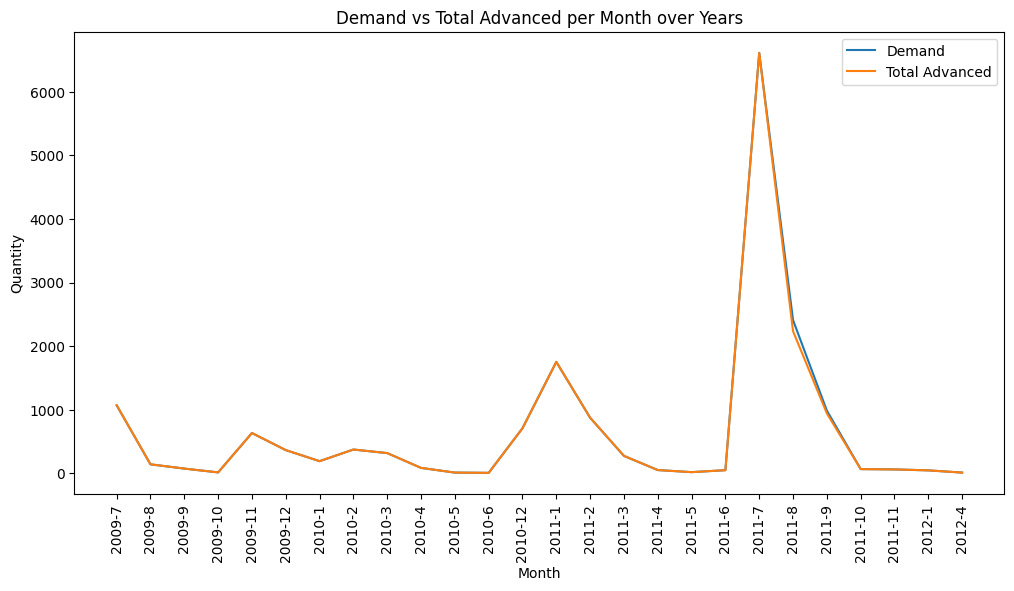

In [2229]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(monthly_df['Order Year'].astype(str) + '-' + monthly_df['Order Month'].astype(str), monthly_df['Demand'], label='Demand')
plt.plot(monthly_df['Order Year'].astype(str) + '-' + monthly_df['Order Month'].astype(str), monthly_df['Total_Advanced'], label='Total Advanced')

plt.xlabel('Month')
plt.ylabel('Quantity')
plt.title('Demand vs Total Advanced per Month over Years')
plt.legend()

plt.xticks(rotation=90)

plt.show()


We can see that the company almost always has orders that require delivery in more than 30 days, making them advanced orders. Only a few times is this not the case (2011 month 8 & 9)

In [2230]:
monthly_df.head()

,Order Year,Order Month,O_Season_Num,Demand,Value,Value/Item,Urgent Items,Advanced_Urgent_Items,Advanced_Items,Lead_Time_Months,Total_Advanced,Previous_Month_Items,Previous_Month_Urgent,Previous_Month_Advanced_Urgent_Items,Previous_Month_Advanced_Items,Previous_Month_Total_Advanced,Demand_Prv_Yr,Total_Advanced_Prev_6_Months
0,2009,7,3,1067,462065.60,431.765957,0,0,1067,6.712963,1067,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2009,8,3,137,45673.86,153.683100,0,0,137,7.400000,137,1067.0,0.0,0.0,1067.0,1067.0,0.0,0.0
2,2009,9,4,70,1692.29,25.672345,0,0,70,6.785714,70,137.0,0.0,0.0,137.0,137.0,0.0,0.0
3,2009,10,4,10,97.42,9.856667,0,0,10,7.000000,10,70.0,0.0,0.0,70.0,70.0,0.0,0.0
4,2009,11,4,630,12492.89,19.829977,0,0,630,8.000000,630,10.0,0.0,0.0,10.0,10.0,0.0,0.0


Remove the first two months as they have NA values, so predictions can only be made by the 3rd month.

In [2231]:
monthly_df_copy = monthly_df.copy()

In [2232]:
monthly_df.dropna(inplace=True)

In [2233]:
X = monthly_df[['Previous_Month_Items','Previous_Month_Urgent', 'Previous_Month_Advanced_Urgent_Items', 'Previous_Month_Advanced_Items','Previous_Month_Total_Advanced', 'Demand_Prv_Yr', 'Total_Advanced_Prev_6_Months']]
y = monthly_df['Demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Ridge()
parameters = {'alpha': [0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

model = Ridge(alpha=best_alpha)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
avg_actual = y.mean()
mae_ratio = mae / avg_actual
print(f"MAE Ratio: {mae_ratio:.4f}")


y_pred = model.predict(X)

predictions = pd.DataFrame({'Year': monthly_df['Order Year'], 'Month': monthly_df['Order Month'], 'O_Season_Num': monthly_df['O_Season_Num'], 'Actual': y, 'Predicted': y_pred})

print(predictions)

Best alpha: 100
Mean Squared Error: 255786.3373
Mean Absolute Error: 485.5055
MAE Ratio: 0.7376
    Year  Month  O_Season_Num  Actual    Predicted
0   2009      7             3    1067   689.534588
1   2009      8             3     137   555.525953
2   2009      9             4      70   672.328231
3   2009     10             4      10   680.743019
4   2009     11             4     630   688.278650
5   2009     12             1     361   610.410464
6   2010      1             1     187   847.352888
7   2010      2             1     370   692.133452
8   2010      3             2     314   656.392922
9   2010      4             2      81   652.002128
10  2010      5             2       7   799.314006
11  2010      6             3       3   757.390129
12  2010     12             1     705   357.418972
13  2011      1             1    1750   624.273252
14  2011      2             1     871   505.431808
15  2011      3             2     270   592.122042
16  2011      4             2      47

In [2234]:
X = monthly_df[['Previous_Month_Items', 'Previous_Month_Advanced_Urgent_Items', 
                'Previous_Month_Advanced_Items', 'Previous_Month_Total_Advanced', 
                'Demand_Prv_Yr']]
y = monthly_df['Demand']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2235]:
categorical_features = []
numerical_features = ['Previous_Month_Items', 'Previous_Month_Advanced_Urgent_Items', 
                      'Previous_Month_Advanced_Items', 'Previous_Month_Total_Advanced', 
                      'Demand_Prv_Yr']

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge())
])

In [2236]:
parameters = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(ridge_pipeline, parameters, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['ridge__alpha']
print(f"Best alpha: {best_alpha}")

ridge_model = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge(alpha=best_alpha))
])

ridge_model.fit(X_train, y_train)

Best alpha: 100


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Previous_Month_Items',
                                                   'Previous_Month_Advanced_Urgent_Items',
                                                   'Previous_Month_Advanced_Items',
                                                   'Previous_Month_Total_Advanced',
                                                   'Demand_Prv_Yr']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('ridge', Ridge(alpha=100))])

In [2237]:
y_pred = ridge_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

avg_actual = y.mean()
mae_ratio = mae / avg_actual
print(f"MAE Ratio: {mae_ratio:.4f}")

y_pred_full = ridge_model.predict(X)

predictions = pd.DataFrame({
    'Year': monthly_df['Order Year'], 
    'Month': monthly_df['Order Month'], 
    'O_Season_Num': monthly_df['O_Season_Num'], 
    'Actual': y, 
    'Predicted': y_pred_full
})


print(predictions)


Mean Squared Error: 360342.7186
Mean Absolute Error: 583.9777
MAE Ratio: 0.8872
    Year  Month  O_Season_Num  Actual    Predicted
0   2009      7             3    1067   695.285291
1   2009      8             3     137   774.180446
2   2009      9             4      70   705.415222
3   2009     10             4      10   700.461168
4   2009     11             4     630   696.024702
5   2009     12             1     361   741.868185
6   2010      1             1     187   721.978029
7   2010      2             1     370   709.112277
8   2010      3             2     314   722.643498
9   2010      4             2      81   718.502797
10  2010      5             2       7   701.274520
11  2010      6             3       3   695.802879
12  2010     12             1     705   745.473871
13  2011      1             1    1750   753.829368
14  2011      2             1     871   827.960263
15  2011      3             2     270   760.156282
16  2011      4             2      47   744.751785
17

In [2238]:
predictions.head()

,Year,Month,O_Season_Num,Actual,Predicted
0,2009,7,3,1067,695.285291
1,2009,8,3,137,774.180446
2,2009,9,4,70,705.415222
3,2009,10,4,10,700.461168
4,2009,11,4,630,696.024702


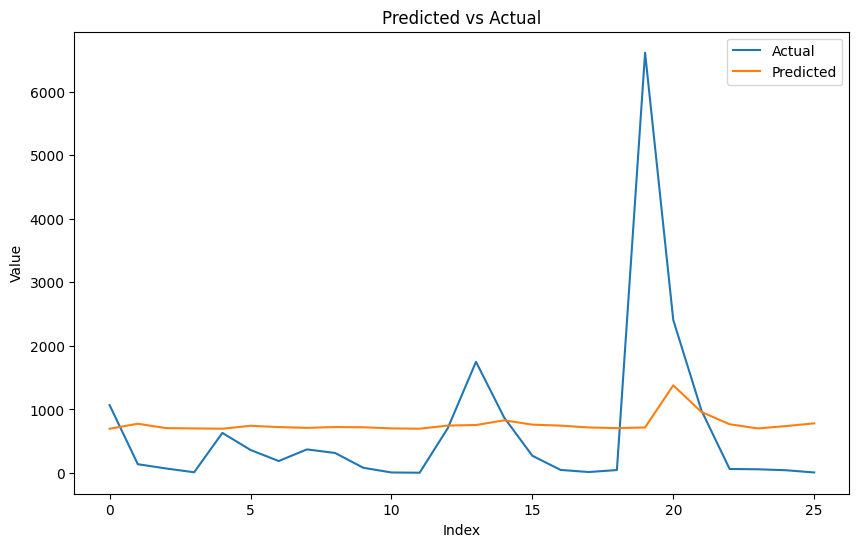

In [2239]:
plt.figure(figsize=(10, 6))
plt.plot(predictions['Actual'], label='Actual')
plt.plot(predictions['Predicted'], label='Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Predicted vs Actual')
plt.legend()
plt.show()


Now that we have our monthly demand estimates, I will combine them with each seasons product choice probability to find out how the projected demand breaks down to a SKU level.

In [2240]:
merged_df = pd.merge(predictions, seasonal_choice_probabilities, left_on='O_Season_Num', right_index=True, how='left')


In [2241]:
merged_df.head()

,Year,Month,O_Season_Num,Actual,Predicted,prob_L10705000,prob_L10705100,prob_L10705200,prob_L10705300,prob_L10705400,...,prob_L12918000,prob_L12918400,prob_L12918500,prob_L12918600,prob_L12918700,prob_L12918800,prob_L12918900,prob_L12919000,prob_L12919100,prob_L12919200
0,2009,7,3,1067,695.285291,0.015675,0.008147,0.010947,0.014206,0.017549,...,0.048033,0.085121,0.065636,0.043142,0.082077,0.020612,0.032533,0.069075,0.029166,0.070898
1,2009,8,3,137,774.180446,0.015675,0.008147,0.010947,0.014206,0.017549,...,0.048033,0.085121,0.065636,0.043142,0.082077,0.020612,0.032533,0.069075,0.029166,0.070898
2,2009,9,4,70,705.415222,0.017605,0.002329,0.004775,0.003472,0.007965,...,0.094921,0.047119,0.046151,0.045772,0.041904,0.025075,0.068831,0.057028,0.019316,0.073699
3,2009,10,4,10,700.461168,0.017605,0.002329,0.004775,0.003472,0.007965,...,0.094921,0.047119,0.046151,0.045772,0.041904,0.025075,0.068831,0.057028,0.019316,0.073699
4,2009,11,4,630,696.024702,0.017605,0.002329,0.004775,0.003472,0.007965,...,0.094921,0.047119,0.046151,0.045772,0.041904,0.025075,0.068831,0.057028,0.019316,0.073699


In [2242]:
merged_df.columns

Index(['Year', 'Month', 'O_Season_Num', 'Actual', 'Predicted',
       'prob_L10705000', 'prob_L10705100', 'prob_L10705200', 'prob_L10705300',
       'prob_L10705400', 'prob_L10705500', 'prob_L10705600', 'prob_L10705700',
       'prob_L10850600', 'prob_L10850700', 'prob_L10850800', 'prob_L10850900',
       'prob_L10852800', 'prob_L10852900', 'prob_L10853100', 'prob_L12134400',
       'prob_L12134500', 'prob_L12134600', 'prob_L12134700', 'prob_L12135800',
       'prob_L12135900', 'prob_L12136000', 'prob_L12136100', 'prob_L12916800',
       'prob_L12916900', 'prob_L12917000', 'prob_L12917100', 'prob_L12917700',
       'prob_L12917800', 'prob_L12917900', 'prob_L12918000', 'prob_L12918400',
       'prob_L12918500', 'prob_L12918600', 'prob_L12918700', 'prob_L12918800',
       'prob_L12918900', 'prob_L12919000', 'prob_L12919100', 'prob_L12919200'],
      dtype='object')

In [2243]:
prob_cols = ['prob_L10705000', 'prob_L10705100', 'prob_L10705200', 'prob_L10705300',
    'prob_L10705400', 'prob_L10705500', 'prob_L10705600', 'prob_L10705700',
    'prob_L10850600', 'prob_L10850700', 'prob_L10850800', 'prob_L10850900',
    'prob_L10852800', 'prob_L10852900', 'prob_L10853100', 'prob_L12134400',
    'prob_L12134500', 'prob_L12134600', 'prob_L12134700', 'prob_L12135800',
    'prob_L12135900', 'prob_L12136000', 'prob_L12136100', 'prob_L12916800',
    'prob_L12916900', 'prob_L12917000', 'prob_L12917100', 'prob_L12917700',
    'prob_L12917800', 'prob_L12917900', 'prob_L12918000', 'prob_L12918400',
    'prob_L12918500', 'prob_L12918600', 'prob_L12918700', 'prob_L12918800',
    'prob_L12918900', 'prob_L12919000', 'prob_L12919100', 'prob_L12919200']

new_cols = [col.split('_')[1] for col in prob_cols]

for prob_col, new_col in zip(prob_cols, new_cols):
    merged_df[new_col] = round(merged_df[prob_col] * merged_df['Predicted']).astype(int)


In [2244]:
merged_df.head(10)

,Year,Month,O_Season_Num,Actual,Predicted,prob_L10705000,prob_L10705100,prob_L10705200,prob_L10705300,prob_L10705400,...,L12918000,L12918400,L12918500,L12918600,L12918700,L12918800,L12918900,L12919000,L12919100,L12919200
0,2009,7,3,1067,695.285291,0.015675,0.008147,0.010947,0.014206,0.017549,...,33,59,46,30,57,14,23,48,20,49
1,2009,8,3,137,774.180446,0.015675,0.008147,0.010947,0.014206,0.017549,...,37,66,51,33,64,16,25,53,23,55
2,2009,9,4,70,705.415222,0.017605,0.002329,0.004775,0.003472,0.007965,...,67,33,33,32,30,18,49,40,14,52
3,2009,10,4,10,700.461168,0.017605,0.002329,0.004775,0.003472,0.007965,...,66,33,32,32,29,18,48,40,14,52
4,2009,11,4,630,696.024702,0.017605,0.002329,0.004775,0.003472,0.007965,...,66,33,32,32,29,17,48,40,13,51
5,2009,12,1,361,741.868185,0.001506,0.000912,0.001122,0.001520,0.001606,...,0,3,1,2,2,0,1,2,1,2
6,2010,1,1,187,721.978029,0.001506,0.000912,0.001122,0.001520,0.001606,...,0,3,1,2,1,0,1,2,1,2
7,2010,2,1,370,709.112277,0.001506,0.000912,0.001122,0.001520,0.001606,...,0,3,1,2,1,0,1,1,1,2
8,2010,3,2,314,722.643498,0.000782,0.000444,0.000394,0.000369,0.001037,...,3,2,1,0,2,0,1,2,0,2
9,2010,4,2,81,718.502797,0.000782,0.000444,0.000394,0.000369,0.001037,...,3,2,1,0,2,0,1,2,0,2


In [2245]:
X = monthly_df[['Previous_Month_Items','Previous_Month_Urgent', 'Previous_Month_Advanced_Urgent_Items', 'Previous_Month_Advanced_Items','Previous_Month_Total_Advanced', 'Demand_Prv_Yr', 'Total_Advanced_Prev_6_Months']]
y = monthly_df['Demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Ridge()
parameters = {'alpha': [0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

model = Ridge(alpha=best_alpha)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
avg_actual = y.mean()
mae_ratio = mae / avg_actual
print(f"MAE Ratio: {mae_ratio:.4f}")


y_pred = model.predict(X)

predictions = pd.DataFrame({'Year': monthly_df['Order Year'], 'Month': monthly_df['Order Month'], 'O_Season_Num': monthly_df['O_Season_Num'], 'Actual': y, 'Predicted': y_pred})

print(predictions)


Best alpha: 100
Mean Squared Error: 255786.3373
Mean Absolute Error: 485.5055
MAE Ratio: 0.7376
    Year  Month  O_Season_Num  Actual    Predicted
0   2009      7             3    1067   689.534588
1   2009      8             3     137   555.525953
2   2009      9             4      70   672.328231
3   2009     10             4      10   680.743019
4   2009     11             4     630   688.278650
5   2009     12             1     361   610.410464
6   2010      1             1     187   847.352888
7   2010      2             1     370   692.133452
8   2010      3             2     314   656.392922
9   2010      4             2      81   652.002128
10  2010      5             2       7   799.314006
11  2010      6             3       3   757.390129
12  2010     12             1     705   357.418972
13  2011      1             1    1750   624.273252
14  2011      2             1     871   505.431808
15  2011      3             2     270   592.122042
16  2011      4             2      47

Let's make a prediciton for next months demand.

In [2246]:
X = monthly_df[['Previous_Month_Items', 'Previous_Month_Urgent', 'Previous_Month_Advanced_Urgent_Items', 'Previous_Month_Advanced_Items', 'Previous_Month_Total_Advanced', 'Demand_Prv_Yr', 'Total_Advanced_Prev_6_Months']]
y = monthly_df['Demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

new_data = pd.DataFrame({'Previous_Month_Items': [monthly_df['Previous_Month_Items'].iloc[-1]], 
                         'Previous_Month_Urgent': [monthly_df['Previous_Month_Urgent'].iloc[-1]], 
                         'Previous_Month_Advanced_Urgent_Items': [monthly_df['Previous_Month_Advanced_Urgent_Items'].iloc[-1]],
                         'Previous_Month_Advanced_Items': [monthly_df['Previous_Month_Advanced_Items'].iloc[-1]],
                         'Previous_Month_Total_Advanced': [monthly_df['Previous_Month_Total_Advanced'].iloc[-1]],
                         'Demand_Prv_Yr': [monthly_df['Demand_Prv_Yr'].iloc[-1]],
                         'Total_Advanced_Prev_6_Months': [monthly_df['Total_Advanced_Prev_6_Months'].iloc[-1]]})

prediction = model.predict(new_data)
print(f"Predicted demand for the next month: {prediction[0]:.2f}")

Predicted demand for the next month: 1333.83
